In [1]:
import os
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics
from covid19prophet import fit_model, cross_validate, tune_hyperparameters, make_forecasts # my own module


# Data Prep

In [4]:
# load data
# os.chdir('/Users/yupinghe/Documents/Futuristic/covid19prophet')

# county-level confirmed cases
df = pd.read_csv('covid19prophet/time_series_covid19_confirmed_US.csv')
print(f'Dataset size: ', {df.shape}, '\n') 
# print(df.columns)
print(df.head())

Dataset size:  {(3261, 128)} 

   UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 5/8/20  5/9/20  5/10/20  5/11/20  5/12/20  5/13/20  \
0 -14.2710 -170.1320  ...      0       0        0        0        0        0   
1  13.4443  144.7937  ...    151     151      151      151      152      152   
2  15.0979  145.6739  ...     15      16       16       19       19       19   
3  18.2208  -66.5901  ...   2156    2173     2198     2256     2299     2329   
4  18.3358  -64.8963  ...     68      68       69       69       69       69   

 

In [5]:

# wide to long
df_ny = df.loc[df['Province_State']=='New York', df.columns[11:].to_list()].melt(
    id_vars=None, 
    value_vars=df.columns[11:].to_list(), 
    var_name='Date', 
    value_name='Cases')

df_ny['Date'] = pd.to_datetime(df_ny['Date'])

# Set to time series
ts_ny = df_ny.set_index(df_ny['Date']).loc[:,['Cases']].resample('D').sum()

# Calcualte daily new cases
ts_ny['Cases_lag1'] = ts_ny.shift(1)
ts_ny['Cases_new'] = ts_ny['Cases'] - ts_ny['Cases_lag1']


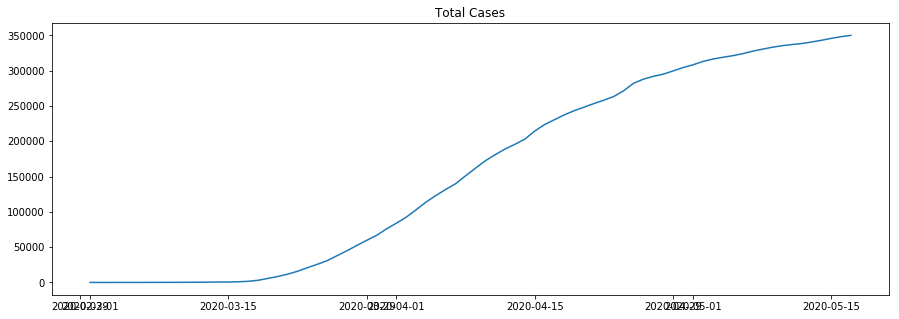

In [6]:

# ts_ny['Cases'].plot()
plt.figure(figsize = [15,5])
plt.plot(ts_ny['2020-03-01':].index, ts_ny.loc['2020-03-01':,['Cases']])
plt.title('Total Cases')
plt.show()

# ts_ny.tail()

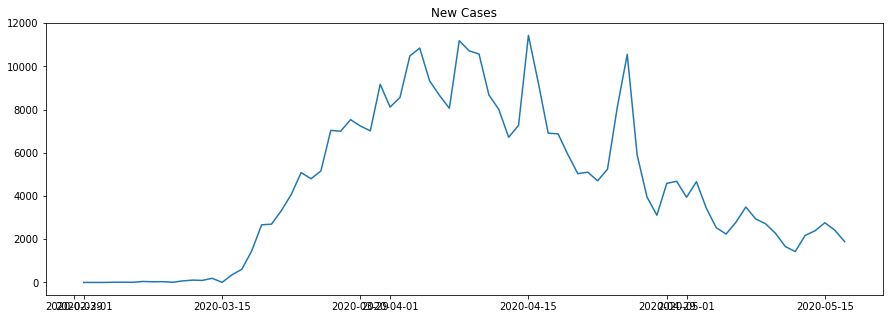

In [7]:
# ts_ny['Cases_new'].hist()

plt.figure(figsize = [15,5])
plt.plot(ts_ny['2020-03-01':].index, ts_ny.loc['2020-03-01':,['Cases_new']])
plt.title('New Cases')
plt.show()

In [8]:
# Propeht format
ts_ny_train = ts_ny.loc['2020-03-01':,['Cases_new']].reset_index().rename(columns={'Date':'ds', 'Cases_new':'y'})

ts_ny_train.tail()

,ds,y
73,2020-05-13,2176.0
74,2020-05-14,2390.0
75,2020-05-15,2762.0
76,2020-05-16,2419.0
77,2020-05-17,1889.0


In [9]:

# my_grid = {
#     'growth': ['linear', 'logistic']
#     ,'changepoint_prior': [0.01, 0.1, 0.5]
#     ,'changepoint_range': [0.8]
#     ,'weekly_fourier_order': [3, 5]
# }


my_grid = {
    'growth': ['logistic']
    ,'changepoint_prior': [0.5]
    ,'changepoint_range': [0.8]
    ,'weekly_fourier_order': [3]
}

params_best = tune_hyperparameters(data=ts_ny_train, model_prophet=fit_model, model_cv=cross_validate, grid=my_grid)

params_best

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-22 00:00:00 and 2020-05-10 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.


,growth,changepoint_prior,changepoint_range,weekly_fourier_order,MAPE
0,logistic,0.5,0.8,3,0.295162


In [10]:
m, forecast = make_forecasts(
        model_prophet=fit_model, 
        best_trend_func=params_best.loc[0,'growth'], 
        best_changepoint_prior=params_best.loc[0,'changepoint_prior'], 
        best_changepoint_range=params_best.loc[0,'changepoint_range'],
        best_weekly_fourier_order=params_best.loc[0,'weekly_fourier_order'], 
        ts=ts_ny_train, 
        horizon=20)

# forecast.head()

# EDA

In [127]:
# plot time series: total vs new cases



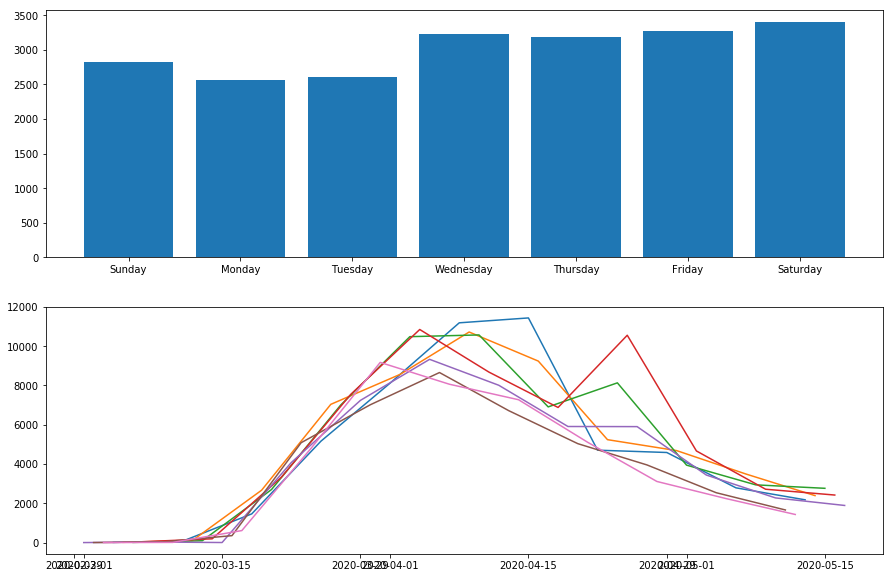

In [126]:
# data for line chart
ts_temp = ts_ny.reset_index()
ts_temp['Weekday'] = ts_temp['Date'].dt.day_name()
ts_temp = ts_temp.set_index('Date')
# data for bar chart
df_temp = ts_temp.groupby(['Weekday'])['Cases_new'].mean()
df_temp = df_temp.reindex(index = ['Sunday', 'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']).reset_index()

# weekly bar chart: total vs new cases
fig, ax = plt.subplots(2, 1, sharey=False, sharex=False, figsize = [15,10])

for day in ts_temp['Weekday'].unique():
    ax[1].plot(ts_temp.loc['2020-03-01':,].loc[ts_temp['Weekday']==day,:].index, 
        ts_temp.loc['2020-03-01':,['Cases_new']].loc[ts_temp['Weekday']==day,:])

ax[0].bar(df_temp['Weekday'], df_temp['Cases_new'])

plt.show()

# Prophet 

## Train vs Test    

In [14]:
# # Propeht format
# ts_ny_train = ts_ny.loc['2020-03-01':,['Cases_new']].reset_index().rename(columns={'Date':'ds', 'Cases_new':'y'})

# ts_ny_train.tail()

,ds,y
73,2020-05-13,2176.0
74,2020-05-14,2390.0
75,2020-05-15,2762.0
76,2020-05-16,2419.0
77,2020-05-17,1889.0


In [51]:
m = Prophet(
    growth='logistic'
    ,weekly_seasonality = True
    ,yearly_seasonality= False
    ,daily_seasonality= False
    ,changepoint_prior_scale = 0.5
    ,changepoint_range = 0.8)

ts_ny_train['cap'] = 12000
ts_ny_train['floor'] = 0

m.fit(ts_ny_train)

# Create Future dates
ts_future = m.make_future_dataframe(periods=30)

ts_future['cap'] = 12000
ts_future['floor'] = 0

# Predict Prices
ts_forecast = m.predict(ts_future)


In [13]:
# trend hyperparameters
trend_func = ['linear', 'logistic']
changepoint_prior = [0.01, 0.1, 0.5]
changepoint_range = [0.8]

# seasonality hyper parameters
weekly_fourier_order = [3, 5]

# Evaluation

In [55]:
# cross- validation

# nee dot make sure that each initial, horizon covers full week??
df_cv = cross_validation(m, initial='21 days', horizon='7 days', period='7 days')

df_p = performance_metrics(df_cv, rolling_window = 1/7)
df_p

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-03-22 00:00:00 and 2020-05-10 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 16.
INFO:fbprophet:n_changepoints greater than number of observations.Using 22.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-03-23,5481.674984,5248.764585,5735.982411,5084.0,2020-03-22
1,2020-03-24,6617.677032,6358.444389,6878.193245,4797.0,2020-03-22
2,2020-03-25,7890.926272,7655.959697,8117.604322,5160.0,2020-03-22
3,2020-03-26,9099.711054,8853.130888,9344.084844,7036.0,2020-03-22
4,2020-03-27,9674.225954,9422.987203,9918.754071,6999.0,2020-03-22
5,2020-03-28,10257.083811,10003.667314,10502.851402,7534.0,2020-03-22
6,2020-03-29,10602.878355,10352.514114,10856.184697,7238.0,2020-03-22


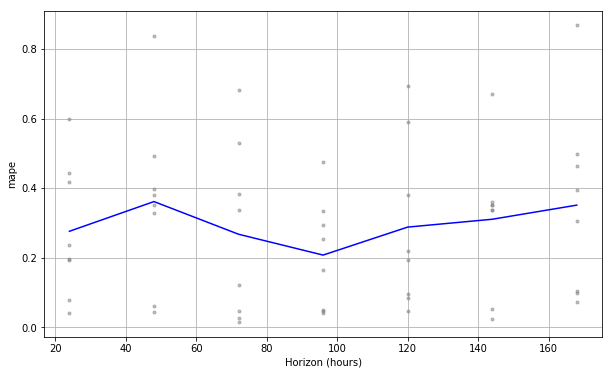

In [57]:
# df_test = performance_metrics(df_cv, rolling_window = 1/7)
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()

# hrs??

# Output

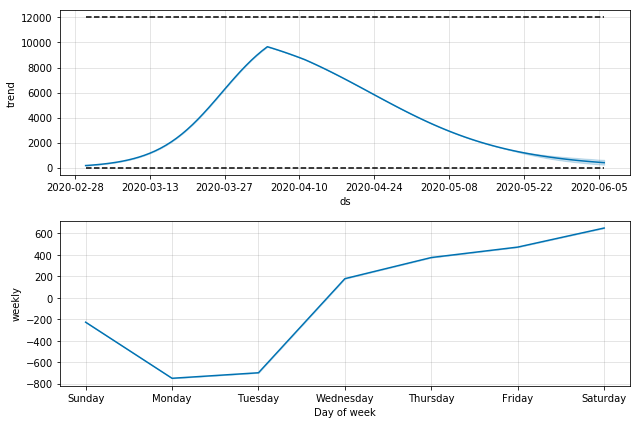

In [11]:
fig = m.plot_components(forecast)

plt.show()

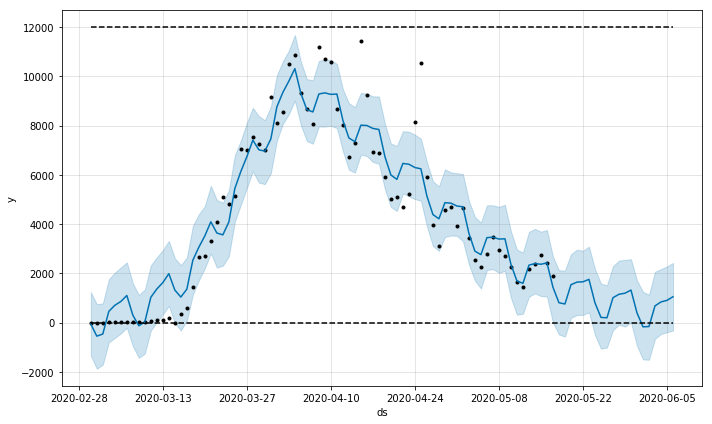

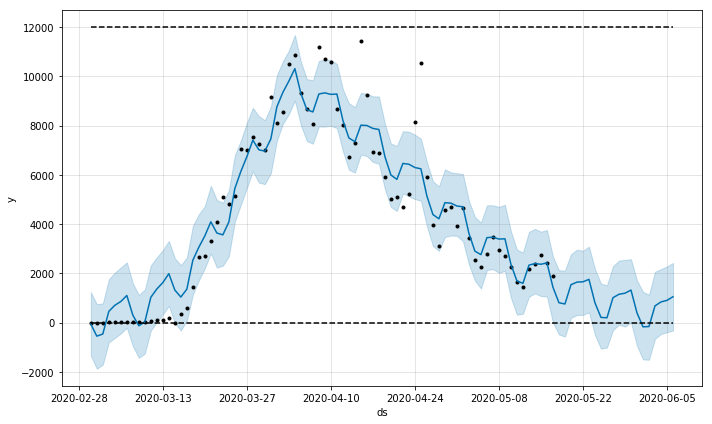

In [12]:
m.plot(forecast)

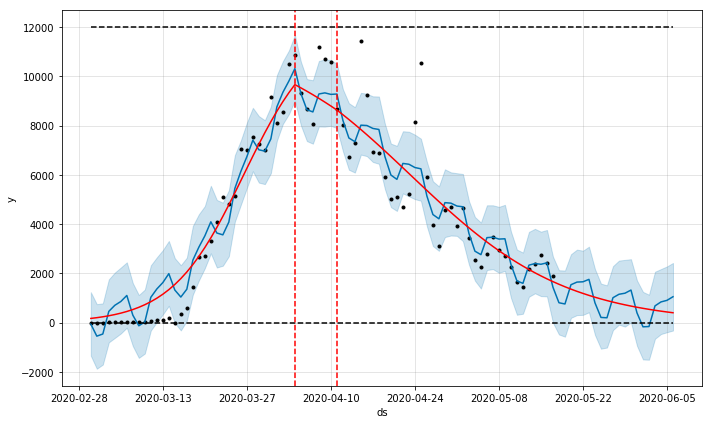

In [13]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

# Production/Application
## Ingest new daily cases
## Update Model Performance